# Train the neural network

In this section, we will discuss how to train the previously defined network with data. We first import the libraries. The new ones are `mxnet.init` for more weight initialization methods, the `datasets` and `transforms` to load and transform computer vision datasets, `matplotlib` for drawing, and `time` for benchmarking.

In [1]:
# Uncomment the following line if matplotlib is not installed.
# !pip install matplotlib

from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time

## Get data

The handwritten digit MNIST dataset is one of the most commonly used datasets in deep learning. But it is too simple to get a 99% accuracy. Here we use a similar but slightly more complicated dataset called FashionMNIST. The goal is no longer to classify numbers, but clothing types instead.

The dataset can be automatically downloaded through Gluon's `data.vision.datasets` module. The following code downloads the training dataset and shows the first example.

In [2]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
('X shape: ', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape: ', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

Each example in this dataset is a $28\times 28$ size grey image, which is presented as NDArray with the shape format of `(height, width, channel)`.  The label is a `numpy` scalar.

Next, we visualize the first six examples.

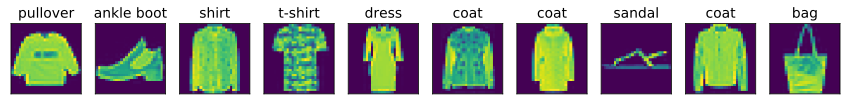

In [3]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
X, y = mnist_train[0:10]
# plot images
display.set_matplotlib_formats('svg')
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In order to feed data into a Gluon model, we need to convert the images to the `(channel, height, width)` format with a floating point data type. It can be done by `transforms.ToTensor`. In addition, we normalize all pixel values with `transforms.Normalize` with the real mean 0.13 and standard deviation 0.31. We chain these two transforms together and apply it to the first element of the data pair, namely the images.

In [4]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])
mnist_train = mnist_train.transform_first(transformer)

`FashionMNIST` is a subclass of `gluon.data.Dataset`, which defines how to get the `i`-th example. In order to use it in training, we need to get a (randomized) batch of examples. It can be easily done by `gluon.data.DataLoader`. Here we use four works to process data in parallel, which is often necessary especially for complex data transforms.

In [5]:
batch_size = 256
train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

The returned `train_data` is an iterable object that yields batches of images and labels pairs.

In [6]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


Finally, we create a validation dataset and data loader.

In [7]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
	batch_size=batch_size, num_workers=4)

## Define the model

We reimplement the same LeNet introduced before. One difference here is that we changed the weight initialization method to `Xavier`, which is a popular choice for deep convolutional neural networks.

In [8]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10))
net.initialize(init=init.Xavier())

Besides the neural network, we need to define the loss function and optimization method for training. We will use standard softmax cross entropy loss for classification problems. It first performs softmax on the output to obtain the predicted probability, and then compares the label with the cross entropy.

In [9]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

The optimization method we pick is the standard stochastic gradient descent with constant learning rate of 0.1.

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

The `trainer` is created with all parameters (both weights and gradients) in `net`. Later on, we only need to call the `step` method to update its weights.

## Train

We create an auxiliary function to calculate the model accuracy.

In [11]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

Now we can implement the complete training loop.

In [12]:
for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)
    # calculate validation accuracy
    for data, label in valid_data:
        valid_acc += acc(net(data), label)
    print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
            epoch, train_loss/len(train_data), train_acc/len(train_data),
            valid_acc/len(valid_data), time.time()-tic))

Epoch 0: loss 0.822, train acc 0.698, test acc 0.811, in 21.3 sec


Epoch 1: loss 0.467, train acc 0.827, test acc 0.846, in 21.5 sec


Epoch 2: loss 0.398, train acc 0.854, test acc 0.859, in 21.7 sec


Epoch 3: loss 0.363, train acc 0.867, test acc 0.877, in 19.1 sec


Epoch 4: loss 0.336, train acc 0.876, test acc 0.879, in 19.2 sec


Epoch 5: loss 0.317, train acc 0.884, test acc 0.887, in 19.1 sec


Epoch 6: loss 0.302, train acc 0.889, test acc 0.890, in 19.2 sec


Epoch 7: loss 0.290, train acc 0.894, test acc 0.895, in 18.7 sec


Epoch 8: loss 0.282, train acc 0.897, test acc 0.889, in 19.2 sec


Epoch 9: loss 0.271, train acc 0.900, test acc 0.895, in 18.2 sec


## Save the model

Finally, we save the trained parameters onto disk, so that we can use them later.

In [13]:
net.save_parameters('net.params')